Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [ ]:
from sklearn.datasets import load_digits

In [ ]:
digits = load_digits()
X = digits.data
y = digits.target
print(f'X.shape = {X.shape[0]}x{X.shape[1]}')
print(f'y.shape = {y.shape[0]}')

X.shape = 1797x64
y.shape = 1797


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plt_digits(data, nrows=3, ncols=4, n=10, shapesize=(8, 8), figsize=(8, 8), title=''):
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  axes = axes.ravel()
  for ax, image in zip(axes, data[:n]):
    ax.set_axis_off()
    ax.imshow(image.reshape(shapesize), cmap=plt.cm.gray_r, interpolation='nearest')
  for ax in axes[n: axes.shape[0]]:
    fig.delaxes(ax)
  fig.suptitle(title, fontsize=20, y=0.95)
  plt.show()

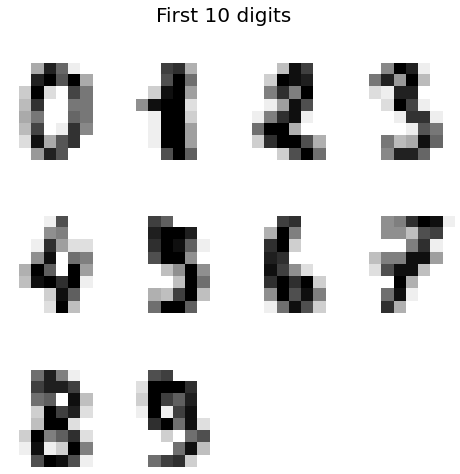

In [ ]:
plt_digits(X, title='First 10 digits')

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [ ]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [ ]:
ac = AgglomerativeClustering(n_clusters=10)
ac_predict = ac.fit_predict(X)

In [ ]:
km = KMeans(n_clusters=10, n_init=100)
km_predict = km.fit_predict(X)

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [ ]:
def plt_predict(predict, title='', shapesize=(8, 8)):
  clusters = []
  for i in range(10):
    clusters.append(X[predict == i].mean(axis=0))
  plt_digits(clusters, title=title, shapesize=shapesize)

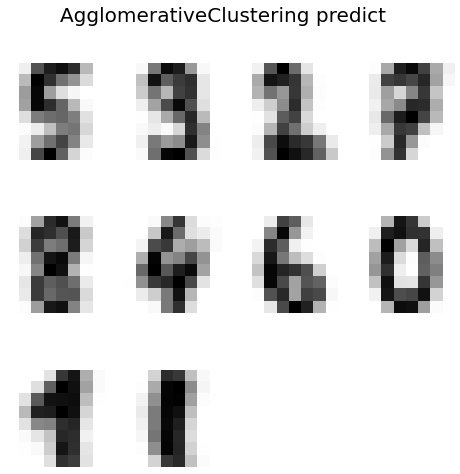

In [ ]:
plt_predict(ac_predict, title='AgglomerativeClustering predict')

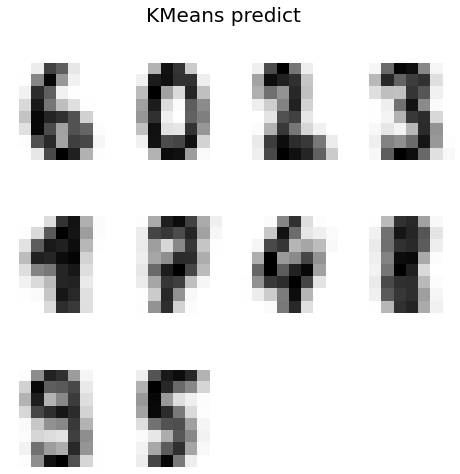

In [ ]:
plt_predict(km_predict, title='KMeans predict')

Мне кажется KMeans больше похож на типичные начертания цифр.

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
predict_ac_n_cl = []
for k in range(2, 21):
  ac = AgglomerativeClustering(n_clusters=k)
  predict_ac_n_cl.append(ac.fit_predict(X))

silhouettes_ac = []
for predict in predict_ac_n_cl:
  silhouettes_ac.append(silhouette_score(X, predict))

In [ ]:
predict_km_n_cl = []
for k in range(2, 21):
  km = KMeans(n_clusters=k, n_init=100)
  predict_km_n_cl.append(km.fit_predict(X))

silhouettes_km = []
for predict in predict_km_n_cl:
  silhouettes_km.append(silhouette_score(X, predict))

In [ ]:
def plt_metrics(metric_ac, metric_km, metric_name):
  plt.plot(metric_ac)
  plt.plot(metric_km)
  max_ac = np.max(metric_ac)
  max_ac_index = metric_ac.index(max_ac)
  max_km = np.max(metric_km)
  max_km_index = metric_km.index(max_km)
  plt.scatter(max_ac_index, max_ac)
  plt.scatter(max_km_index, max_km)
  plt.xticks(ticks=range(0, 19), labels=range(2, 21))
  plt.xlabel('n_clusters')
  plt.ylabel(metric_name)
  plt.legend(['Agglomerative Clustering',
              'KMeans',
              f'Max {metric_name} {np.round(max_ac, 2)} in {max_ac_index + 2} clusters',
              f'Max {metric_name} {np.round(max_km, 2)} in {max_km_index + 2} clusters'])
  plt.title(f'Metric {metric_name}', fontsize=20, y=1.05)
  plt.show()

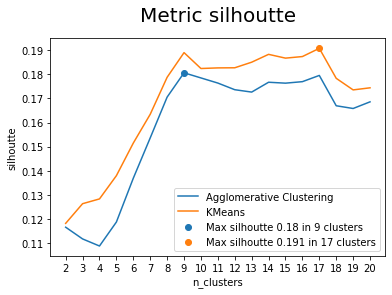

In [ ]:
plt_metrics(silhouettes_ac, silhouettes_km, 'silhoutte')

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [ ]:
from sklearn.metrics import v_measure_score

In [ ]:
v_measure_score_ac= []
for predict in predict_ac_n_cl:
  v_measure_score_ac.append(v_measure_score(y, predict))
v_measure_score_km = []
for predict in predict_km_n_cl:
  v_measure_score_km.append(v_measure_score(y, predict))

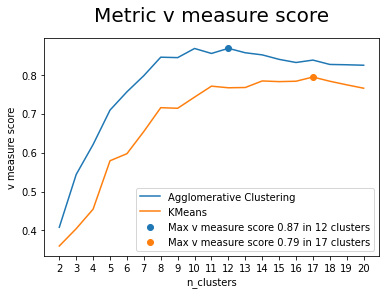

In [ ]:
plt_metrics(v_measure_score_ac, v_measure_score_km, 'v measure score')

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
km = KMeans(n_clusters=10, n_init=100)
predict_truncated = []
for i in [2, 5, 10, 20]:
  tsvd = TruncatedSVD(n_components=i)
  X_truncated = tsvd.fit_transform(X)
  predict_truncated.append(km.fit_predict(X_truncated))

v_measure_score_truncated = []
for predict in predict_truncated:
  v_measure_score_truncated.append(v_measure_score(y, predict))

In [ ]:
def plt_truncated(score, name):
  plt.plot(score)
  max = np.max(score)
  max_index = score.index(max)
  labels=[2, 5, 10, 20]
  plt.scatter(max_index, max)
  plt.xticks(ticks=range(0, 4), labels=labels)
  plt.xlabel('n clusters')
  plt.ylabel('v measure score')
  plt.legend(['KMeans',
              f'Max v measure score {np.round(max, 2)} in {labels[max_index]} components'])
  plt.title(f'Decomposition {name}', fontsize=20, y=1.05)
  plt.show()

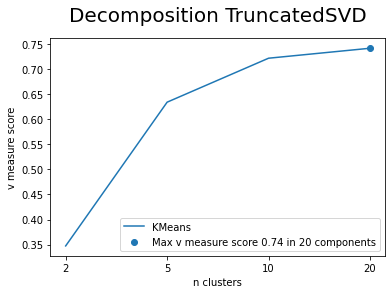

In [ ]:
plt_truncated(v_measure_score_truncated, 'TruncatedSVD')

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X)

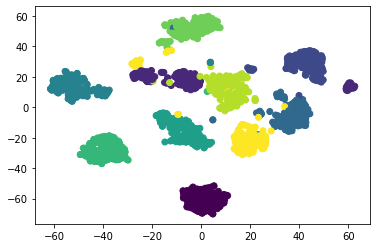

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.show()

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [ ]:
def clusters_print(predict, silhouette, v_measure):
  silhouette_tsne = silhouette_score(X_truncated, predict)
  v_measure_score_tsne = v_measure_score(y, predict)
  print(f'''silhoutte = {round(silhouette_tsne, 2)} {'>' if silhouette_tsne > silhouette else '<' if silhouette_tsne < silhouette else '='} {round(silhouette, 2)}
v measure score = {round(v_measure_score_tsne, 2)} {'>' if v_measure_score_tsne > v_measure else '<' if v_measure_score_tsne < v_measure else '='} {round(v_measure, 2)}''')

In [ ]:
ac_predic_tsne = AgglomerativeClustering(n_clusters=10).fit_predict(X_tsne)
km_predic_tsne = KMeans(n_clusters=10, n_init=100).fit_predict(X_tsne)

In [ ]:
clusters_print(ac_predic_tsne, np.max(silhouettes_ac), np.max(v_measure_score_ac))

silhoutte = 0.19 > 0.18
v measure score = 0.91 > 0.87


In [ ]:
clusters_print(km_predic_tsne, np.max(silhouettes_km), np.max(v_measure_score_km))

silhoutte = 0.19 > 0.19
v measure score = 0.91 > 0.8


Удалость получить лучшие результаты с помощью tSNE

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

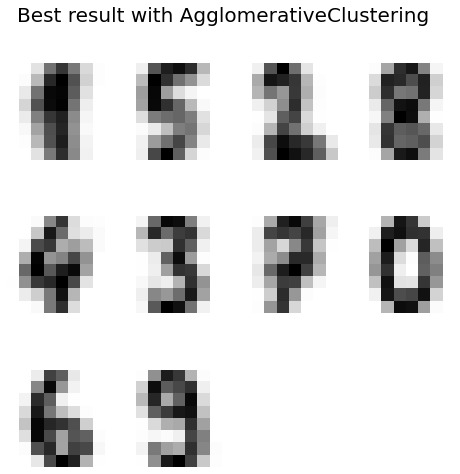

In [ ]:
plt_predict(ac_predic_tsne, title='Best result with AgglomerativeClustering')

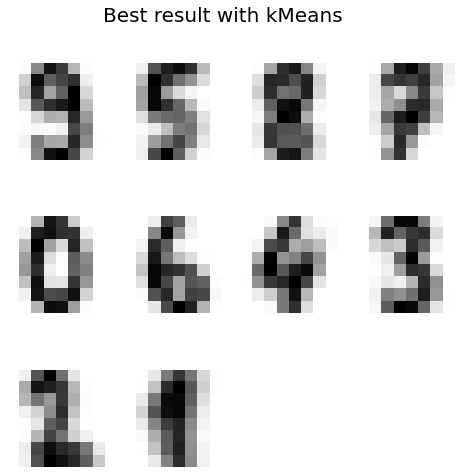

In [ ]:
plt_predict(km_predic_tsne, title='Best result with kMeans')

Удалось добиться лучшего результата. Читаемость цифр увеличилось довольно значительно. Особенно хорошо видно на цифре 8

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

AgglomerativeClustering и kMeans показали примерно похожий результат. Но при этом kMeans больше зависит от гиперпараметров и обладает большей гибкостью. Еще kMeans меньше требует оперативной памяти при работе с большими данными. Эти методы классификации не зависят от методов оценки качества. Качество предсказания улучшается значительно, при снижении размерности признакового пространства.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](https://stackoverflow.com/a/60450028). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [ ]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

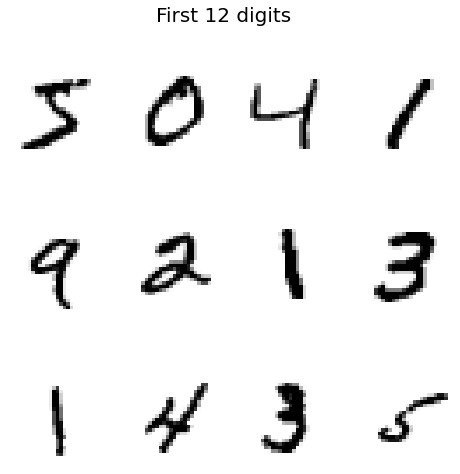

In [ ]:
plt_digits(X, title='First 12 digits', n=12, shapesize=(28, 28))

In [ ]:
X_tsne = TSNE().fit_transform(X)

In [ ]:
#np.savetxt('x_tsne.csv', X_tsne)

In [ ]:
#X_tsne = np.genfromtxt('x_tsne.csv')

In [ ]:
X_tsne.shape

(70000, 2)

In [ ]:
km = KMeans(n_clusters=10, n_init=50)
km_predict = km.fit_predict(X_tsne)

In [ ]:
km_predict

array([0, 4, 9, ..., 9, 3, 6], dtype=int32)

In [ ]:
silhouette_score(X_tsne, km_predict)

0.4102072261414501

In [ ]:
v_measure_score(km_predict, y)

0.8319485372268834

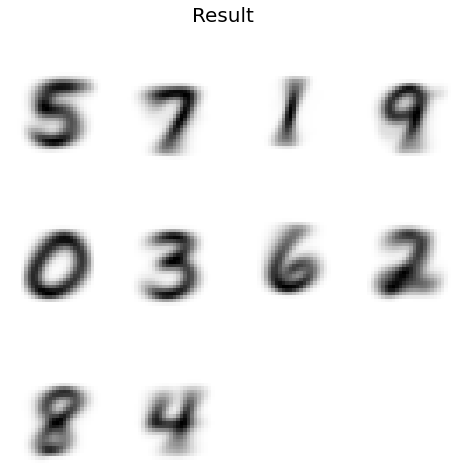

In [ ]:
plt_predict(km_predict, title='Result', shapesize=(28, 28))